## Designing a Predictive Maintenance Model


(adapted from [Predictive Maintenance Modelling Guide Python Notebook](https://gallery.azure.ai/Notebook/Predictive-Maintenance-Modelling-Guide-Python-Notebook-1))

A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs that are associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which will reduce the costly impact caused by downtime. Please refer to the playbook for predictive maintenance for a detailed explanation of common use cases in predictive maintenance and modelling approaches.

In this notebook, we follow the ideas from the playbook referenced above and aim to provide the steps of implementing a predictive model for a scenario which is based on a synthesis of multiple real-world business problems. This example brings together common data elements observed among many predictive maintenance use cases and the data itself is created by data simulation methods.

The business problem for this example is about predicting problems caused by component failures such that the question "What is the probability that a machine will fail in the near future due to a failure of a certain component?" can be answered. The problem is formatted as a multi-class classification problem and a machine learning algorithm is used to create the predictive model that learns from historical data collected from machines. In the following sections, we go through the steps of implementing such a model which are feature engineering, label construction, training and evaluation. First, we start by explaining the data sources in the next section.



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os.path
import urllib.request 
 
import pylab as plt
import seaborn as sns

pd.set_option("display.max_rows",8)
sns.set_style("darkgrid")

### Data Sources
Common data sources for predictive maintenance problems are :

- Failure history: The failure history of a machine or component within the machine.
- Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
- Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
- Machine features: The features of a machine, e.g. engine size, make and model, location.
- Operator features: The features of the operator, e.g. gender, past experience

The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.



In [10]:
# check to see if the data has already been downloaded.  if not, then download it.
if not os.path.isfile('data/PdM_telemetry.csv'):
    urllib.request.urlretrieve('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_telemetry.csv', 'data/PdM_telemetry.csv')
    
if not os.path.isfile('data/PdM_errors.csv'):
    urllib.request.urlretrieve('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_errors.csv', 'data/PdM_errors.csv')

if not os.path.isfile('data/PdM_maint.csv'):
    urllib.request.urlretrieve('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_maint.csv', 'data/PdM_maint.csv')

if not os.path.isfile('data/PdM_failures.csv'):
    urllib.request.urlretrieve('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_failures.csv', 'data/PdM_failures.csv')

if not os.path.isfile('data/PdM_machines.csv'):
    urllib.request.urlretrieve('https://azuremlsampleexperiments.blob.core.windows.net/datasets/PdM_machines.csv', 'data/PdM_machines.csv')


### Telemetry 
Time series data from 100 machines., with voltage, rotation, pressure and vibration measurements. Data are averaged over an hour, collected during 2015.

In [11]:
telemetry = pd.read_csv('data/PdM_telemetry.csv')
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

In [37]:
telemetry

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
...,...,...,...,...,...,...
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259
876099,2016-01-01 06:00:00,100,171.336037,496.096870,79.095538,37.845245


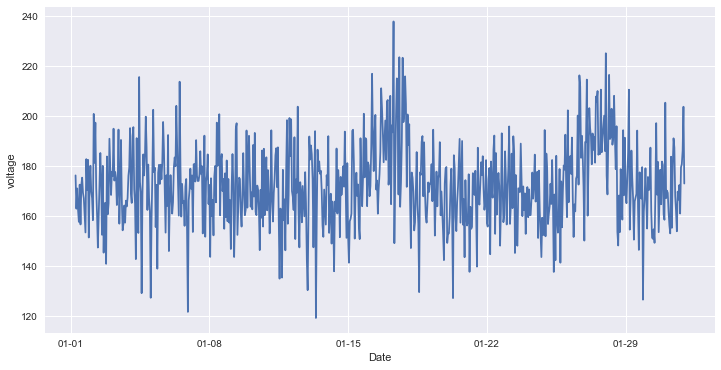

In [13]:
plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')),
                        ['datetime', 'volt']]

plt.figure(figsize=(12, 6))
plt.plot(plot_df['datetime'], plot_df['volt'])
plt.ylabel('voltage')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d'
plt.xlabel('Date')

### Error codes
The second major data source are error logs.  
- non-breaking error codes thrown while machine is operational.
- resampled to closest hour to match with telemetry data

             datetime  machineID errorID
0 2015-01-03 07:00:00          1  error1
1 2015-01-03 20:00:00          1  error3
2 2015-01-04 06:00:00          1  error5
3 2015-01-10 15:00:00          1  error4
4 2015-01-22 10:00:00          1  error4


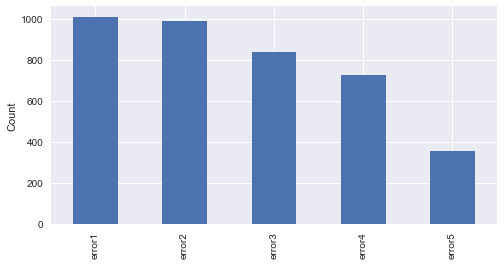

In [14]:
errors = pd.read_csv('data/PdM_errors.csv')
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')

print(errors.head())

plt.figure(figsize=(8, 4))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')

### Maintenance
These are maintenance records.  Generated if component is replace during the scheduled inspection or replaced due to breakdown.  Replacements due to breakdowns are failures.  

             datetime  machineID   comp
0 2014-06-01 06:00:00          1  comp2
1 2014-07-16 06:00:00          1  comp4
2 2014-07-31 06:00:00          1  comp3
3 2014-12-13 06:00:00          1  comp1
4 2015-01-05 06:00:00          1  comp4


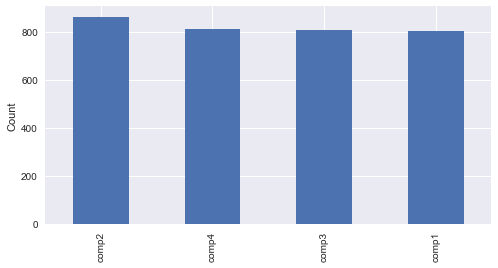

In [15]:
maint = pd.read_csv('data/PdM_maint.csv')
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')

print(maint.head())

plt.figure(figsize=(8, 4))
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Count')

### Machines
This data includes information about the machines: model type and age (years in service).

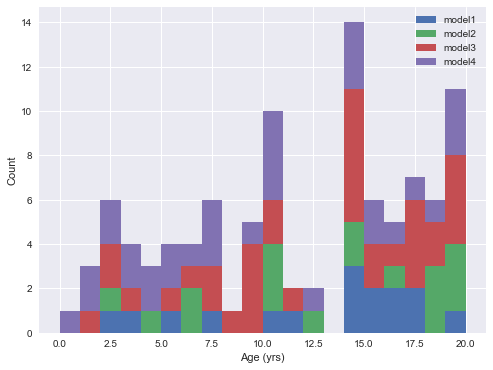

In [16]:
machines = pd.read_csv('data/PdM_machines.csv')
machines['model'] = machines['model'].astype('category')

plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

### Failures
Records of component replacements due to failures.  Each record has a date and time, machine ID and failed component type.

Below is a histogram of the failures due to each component. We see that the most failures happen due to component 2.

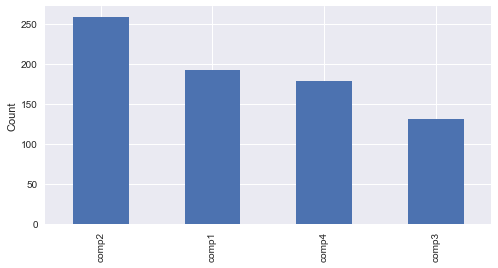

In [17]:
failures = pd.read_csv('data/PdM_failures.csv')
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

plt.figure(figsize=(8, 4))
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Count')

## Feature Engineering
Create features that best describe the health of a machine.  Several features can be used depending on the data source.

### Lagged features
Time series data makes it easy to create lagged features.  Pick a window size and compute rolling aggregate measures such as mean, std deviation, min, max, etc.

In this example, we compute rolling mean, and standard deviation of time series data over 3 hour log windows.

In [36]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
...,...,...,...,...,...,...
292096,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705
292097,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232
292098,100,2016-01-01 06:00:00,182.525427,435.932056,98.798172,42.757630
292099,100,2016-01-01 09:00:00,171.336037,496.096870,79.095538,37.845245


Longer term effects can be captured by using a longer time window.  We also calculate the 24hr lagged features:

In [19]:
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    pt = pd.pivot_table(telemetry,
                        index='datetime',
                        columns='machineID',
                        values=col)
    val = pt.rolling(window=24).mean()
    temp.append(val.resample('3H', closed='left', label='right').first().unstack())
    
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                            index='datetime',
                            columns='machineID',
                            values=col).rolling(window=24).std().resample('3H',
                                                                          closed='left',
                                                                          label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(10)

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
...,...,...,...,...,...,...
13,1,2015-01-03 00:00:00,168.460525,451.031783,99.273286,38.903462
14,1,2015-01-03 03:00:00,169.772951,447.502464,99.005946,39.389725
15,1,2015-01-03 06:00:00,170.900562,453.864597,100.877342,38.696225
16,1,2015-01-03 09:00:00,169.533156,454.785072,100.050567,39.449734


Now merge lagged features in a single dataframe.

In [20]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.771416,446.612973,100.855301,40.384328,13.299858,44.456335,8.885822,4.440660,170.772579,446.613440,100.854547,40.384564,14.918849,49.947916,10.046687,5.002065
std,28.86612,9.497201,33.122865,7.408854,3.476641,6.966647,23.216421,4.656341,2.320066,4.716970,18.074248,4.733098,2.059861,2.260726,7.682126,1.713726,0.799820
min,1.00000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.445576,427.568132,96.238173,38.147839,8.027455,26.903567,5.370647,2.684308,168.070890,441.549802,98.668589,39.354062,13.358663,44.668824,8.924317,4.460347
50%,50.50000,170.430790,448.385564,100.233139,40.146085,12.495595,41.795700,8.345785,4.173854,170.210913,449.212554,100.097694,40.072752,14.853948,49.613807,9.921407,4.958594
75%,75.25000,176.607051,468.447680,104.404520,42.227392,17.689118,59.103715,11.789645,5.898997,172.459612,456.368008,101.611121,40.833364,16.394764,54.821318,10.980498,5.484480
max,100.00000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,220.782618,499.096975,152.310351,61.932124,27.664538,103.819404,28.654103,12.325783


### Lag features from errors
Errors come with timestamps.  errors are categorical data though, and can't be averaged over time intervals.  Instead, count the number of errors of each type in each lag window.  First, reformat the data to have one entry per machine per time when at least one error occured:

In [21]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head(13)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
...,...,...,...,...,...,...,...
9,1,2015-03-20 18:00:00,1,0,0,0,0
10,1,2015-03-26 01:00:00,0,1,0,0,0
11,1,2015-03-31 23:00:00,1,0,0,0,0
12,1,2015-04-19 06:00:00,0,1,1,0,0


Add blank entries for all hourly timepoints with no error codes:

In [22]:
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.head(13)

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
9,2015-01-01 15:00:00,1,0.0,0.0,0.0,0.0,0.0
10,2015-01-01 16:00:00,1,0.0,0.0,0.0,0.0,0.0
11,2015-01-01 17:00:00,1,0.0,0.0,0.0,0.0,0.0
12,2015-01-01 18:00:00,1,0.0,0.0,0.0,0.0,0.0


Finally, we can compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:

In [23]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).sum().resample('3H',
                                                                closed='left',
                                                                label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


### Days Since Last Replacement from Maintenance
A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

In [24]:
# create a column for each error type
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp].astype('datetime64[ns]')) / np.timedelta64(1, 'D')
    
comp_rep.describe()

,machineID,comp1,comp2,comp3,comp4
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


### Machine Features
The machine features can be used without further modification. These include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [29]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291296,100,2015-12-31 21:00:00,166.078945,424.431184,98.344409,30.907459,29.351231,69.348245,16.940674,3.731256,...,0.0,0.0,0.0,0.0,82.625,7.625,82.625,52.625,model4,5
291297,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705,9.605817,78.036116,9.154932,3.379639,...,0.0,0.0,0.0,0.0,82.750,7.750,82.750,52.750,model4,5
291298,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232,8.457322,43.021553,0.785721,3.198928,...,0.0,0.0,0.0,0.0,82.875,7.875,82.875,52.875,model4,5
291299,100,2016-01-01 06:00:00,182.525427,435.932056,98.798172,42.757630,14.835200,19.208302,5.002788,6.836757,...,0.0,0.0,0.0,0.0,83.000,8.000,83.000,53.000,model4,5


## Label Construction
When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "normal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.

In [27]:
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features['failure'] = labeled_features['failure'].astype('object').fillna(method='bfill', limit=7).fillna('none')
#labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
#labeled_features = labeled_features.fillna('none')
#labeled_features['failure'] = labeled_features['failure'].cat.add_categories(['none']).fillna('none')


In [28]:
labeled_features

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291337,100,2015-12-31 21:00:00,166.078945,424.431184,98.344409,30.907459,29.351231,69.348245,16.940674,3.731256,...,0.0,0.0,0.0,82.625,7.625,82.625,52.625,model4,5,none
291338,100,2016-01-01 00:00:00,158.327984,504.056262,108.055441,40.109705,9.605817,78.036116,9.154932,3.379639,...,0.0,0.0,0.0,82.750,7.750,82.750,52.750,model4,5,none
291339,100,2016-01-01 03:00:00,170.306956,438.653616,102.346227,47.481232,8.457322,43.021553,0.785721,3.198928,...,0.0,0.0,0.0,82.875,7.875,82.875,52.875,model4,5,none
291340,100,2016-01-01 06:00:00,182.525427,435.932056,98.798172,42.757630,14.835200,19.208302,5.002788,6.836757,...,0.0,0.0,0.0,83.000,8.000,83.000,53.000,model4,5,none


Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4.

In [29]:
labeled_features.loc[labeled_features['failure'] == 'comp4'][:16]

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
17,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,1.0,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,comp4
18,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,1.0,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,comp4
19,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,1.0,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,comp4
20,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,1.0,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,comp4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,1,2015-06-18 21:00:00,158.851795,520.113831,101.974559,44.156671,14.554854,77.101968,4.788908,5.468742,...,0.0,0.0,1.0,89.625,29.625,14.625,134.625,model3,18,comp4
1342,1,2015-06-19 00:00:00,162.191516,453.545010,101.521779,49.136659,12.553190,33.332139,5.983913,1.893250,...,0.0,0.0,1.0,89.750,29.750,14.750,134.750,model3,18,comp4
1343,1,2015-06-19 03:00:00,166.732741,485.036994,100.284288,44.587560,11.099161,57.308864,3.052958,3.062215,...,0.0,0.0,1.0,89.875,29.875,14.875,134.875,model3,18,comp4
1344,1,2015-06-19 06:00:00,172.059069,463.242610,96.905050,53.701413,14.757880,55.874000,3.204981,2.329615,...,0.0,0.0,1.0,0.000,30.000,15.000,0.000,model3,18,comp4


## Modelling
After the feature engineering and labelling steps, this notebook can be used to create a predictive model. Below, we describe the modelling process and provide an example Python model.

### Training, Validation and Testing
When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is done by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.

In [35]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

train_y = labeled_features.loc[labeled_features['datetime'] < threshold_dates[0][0], 'failure']

train_y

train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < threshold_dates[0][0]].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
train_X

,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
0,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,...,0.0,20.000,215.000,155.000,170.000,18,0,0,1,0
1,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,...,0.0,20.125,215.125,155.125,170.125,18,0,0,1,0
2,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,...,0.0,20.250,215.250,155.250,170.250,18,0,0,1,0
3,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,...,0.0,20.375,215.375,155.375,170.375,18,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290103,173.083263,438.704284,94.424390,39.083103,11.783864,66.494982,9.682734,6.214271,169.631344,440.478164,...,0.0,3.375,3.375,18.375,63.375,5,0,0,0,1
290104,174.048390,433.016353,99.925802,40.676765,4.574859,25.076437,11.605534,5.577813,171.633464,441.192273,...,0.0,3.500,3.500,18.500,63.500,5,0,0,0,1
290105,167.883990,435.511531,96.602542,38.877619,10.131349,55.710554,1.266057,7.099589,172.057946,441.976196,...,0.0,3.625,3.625,18.625,63.625,5,0,0,0,1
290106,176.781659,442.259006,97.540743,37.500466,27.590127,46.843177,14.603949,2.434314,174.085793,440.105220,...,0.0,3.750,3.750,18.750,63.750,5,0,0,0,1


In [33]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'failure'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'failure'], 1))
    # train and predict using the model, storing results for later
    # my_model = GradientBoostingClassifier(random_state=42)
    my_model = RandomForestClassifier(random_state=42, n_jobs=4)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model)



Below, we plot the feature importances in the (first) trained model:

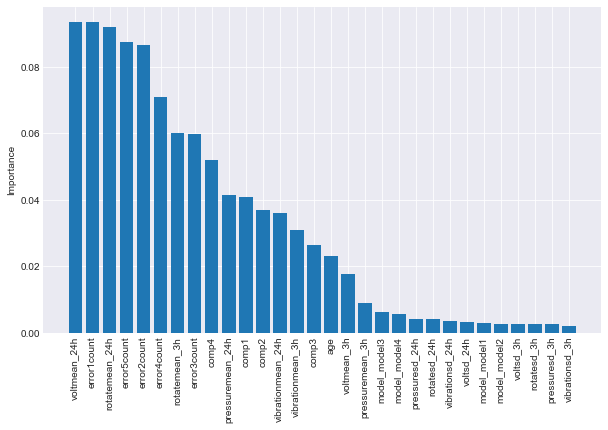

In [34]:
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

## Evaluation
In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

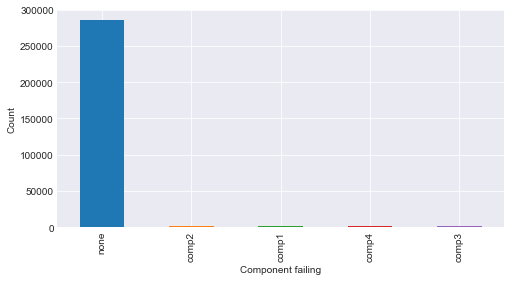

In [35]:
plt.figure(figsize=(8, 4))
labeled_features['failure'].value_counts().plot(kind='bar')
plt.xlabel('Component failing')
plt.ylabel('Count')

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The comparison will bring out the value and benefits of using a machine learning model better.

In the following, we use an evaluation function that computes many important evaluation metrics along with baseline metrics for classification problems. For a detailed explanation of the metrics, please refer to the scikit-learn documentation and a companion blog post (with examples in R, not Python), [Computing Classification Evaluation Metrics in R](http://blog.revolutionanalytics.com/2016/03/com_class_eval_metrics_r.html).

In [36]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [37]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['failure'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'comp1', 'comp2', 'comp3', 'comp4'])
    evaluation_results.append(evaluation_result)
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[120297     14      0      0      2]
 [    28    509      3      0      2]
 [     0      2    867      0      0]
 [    18      3      2    363      2]
 [     2      2      7      0    496]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[95969     8     0     0     0]
 [   37   381     2     0     2]
 [    4     1   702     0     1]
 [   16     1     2   286     1]
 [    7     1     3     1   388]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[72420     6     0     1     2]
 [   28   289     2     0     1]
 [    4     0   552     0     0]
 [   13     1     0   208     2]
 [    1     2     3     0   274]]


,none,comp1,comp2,comp3,comp4
accuracy,0.999290,0.999290,0.999290,0.999290,0.999290
precision,0.999601,0.960377,0.986348,1.000000,0.988048
recall,0.999867,0.939114,0.997699,0.935567,0.978304
F1,0.999734,0.949627,0.991991,0.966711,0.983152
...,...,...,...,...,...
random weighted guess accuracy,0.962838,0.962838,0.962838,0.962838,0.962838
random weighted guess precision,0.981194,0.004420,0.007087,0.003164,0.004135
random weighted guess recall,0.981194,0.004420,0.007087,0.003164,0.004135
random weighted guess F1,0.981194,0.004420,0.007087,0.003164,0.004135


In predictive maintenance, we are often most concerned with how many of the actual failures were predicted by the model, i.e. the model's recall. (Recall becomes more important as the consequences of false negatives -- true failures that the model did not predict -- exceed the consequences of false positives, viz. false prediction of impending failure.) Below, we compare the recall rates for each failure type for the three models. The recall rates for all components as well as no failure are all above 90% meaning the model was able to capture above 90% of the failures correctly.

In [38]:
recall_df = pd.DataFrame([evaluation_results[0].loc['recall'].values,
                          evaluation_results[1].loc['recall'].values,
                          evaluation_results[2].loc['recall'].values],
                          columns = ['none', 'comp1', 'comp2', 'comp3', 'comp4'],
                          index = ['recall for first split',
                                  'recall for second split',
                                  'recall for third split'])
recall_df

,none,comp1,comp2,comp3,comp4
recall for first split,0.999867,0.939114,0.997699,0.935567,0.978304
recall for second split,0.999917,0.902844,0.991525,0.934641,0.970000
recall for third split,0.999876,0.903125,0.992806,0.928571,0.978571


## Summary
In this notebook, the steps of implementing a predictive maintenance model is provided using an example scenario where the goal is to predict failures due to certain components of a machine. Typical steps of predictive maintenance such as feature engineering, labelling, training and evaluation are explained using the example data sets.